In [55]:
import pandas as pd
import numpy as np

from dateutil.parser import parse
from datetime import datetime
import dateutil.parser


import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns


import glob
import os
import zipfile

In [56]:
# read in an 2017 data 
df = pd.read_csv("combined_csv.txt")

In [57]:
df.rename(columns = {
    'C/A': 'area',
    'UNIT': 'unit',
    'SCP': 'scp',
    'STATION': 'station',
    'LINENAME': 'linename',
    'DIVISION': 'division',
    'DATE': 'date',
    'TIME': 'time',
    'DESC': 'desc',
    'ENTRIES': 'entries',
    'EXITS                                                               ': 'exits'},
    inplace = True)

In [62]:
df.shape

(2562223, 11)

In [59]:
# filter for our top stations of 23 ST, CANAL ST, 14 ST, 28 ST, CHAMBERS ST

df_top_stations = df.loc[(df['station'] == '23 ST') | (df['station'] == 'CANAL ST') | (df['station'] == '14 ST') | (df['station'] == '28 ST') | (df['station'] == 'CHAMBERS ST')]
 


In [66]:
df_top_stations.describe

<bound method NDFrame.describe of          area  unit       scp station linename division        date      time  \
3563     A027  R082  01-00-00   28 ST      NRW      BMT  04/08/2017  00:00:00   
3564     A027  R082  01-00-00   28 ST      NRW      BMT  04/08/2017  04:00:00   
3565     A027  R082  01-00-00   28 ST      NRW      BMT  04/08/2017  08:00:00   
3566     A027  R082  01-00-00   28 ST      NRW      BMT  04/08/2017  12:00:00   
3567     A027  R082  01-00-00   28 ST      NRW      BMT  04/08/2017  16:00:00   
3568     A027  R082  01-00-00   28 ST      NRW      BMT  04/08/2017  20:00:00   
3569     A027  R082  01-00-00   28 ST      NRW      BMT  04/09/2017  00:00:00   
3570     A027  R082  01-00-00   28 ST      NRW      BMT  04/09/2017  04:00:00   
3571     A027  R082  01-00-00   28 ST      NRW      BMT  04/09/2017  08:00:00   
3572     A027  R082  01-00-00   28 ST      NRW      BMT  04/09/2017  12:00:00   
3573     A027  R082  01-00-00   28 ST      NRW      BMT  04/09/2017  16:00:

In [67]:
#Make a python dict where there is a key for each (C/A, UNIT, SCP, STATION). These are the first four columns. 
#The value for this key is a list of lists. Each list in the list is the rest of the columns in a row

df_dict = {}
for index, row in df_top_stations.iterrows():
    key = tuple(row[df_top_stations.columns[0:4]].values)
    val = list(row[df_top_stations.columns[4:]].values)
    df_dict[key] = df_dict.get(key,[]) + [val]

In [68]:
# For each key (basically the control area, unit, device address and station of a specific turnstile), 
#have a list again, but let the list be comprised of just the point in time and the count of entries.

my_dict_2 = {}
for index, row in df_top_stations.iterrows():
    key = tuple(row[df_top_stations.columns[0:4]].values)
    datetime_str = row['date'] + ' ' + row['time']
    datetime_parsed = dateutil.parser.parse(datetime_str) 
    val = [datetime_parsed, row['entries']]
    my_dict_2[key] = my_dict_2.get(key,[]) + [val]

In [73]:
# dataset is cumulative so we are taking the difference between the current and prior collection period
# we are then summing up both the entries and exit differences to get the total in the column

df_top_stations['entries_diff'] = df_top_stations['entries'].diff(1);
df_top_stations['exits_diff'] = df_top_stations['exits'].diff(1);
df_top_stations['total_traffic'] = df_top_stations['entries_diff'] + df_top_stations['exits_diff']

/Users/nicksherwin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/nicksherwin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Users/nicksherwin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

In [74]:
df_top_stations.head()

area  unit       scp station linename division        date      time  \
3563  A027  R082  01-00-00   28 ST      NRW      BMT  04/08/2017  00:00:00   
3564  A027  R082  01-00-00   28 ST      NRW      BMT  04/08/2017  04:00:00   
3565  A027  R082  01-00-00   28 ST      NRW      BMT  04/08/2017  08:00:00   
3566  A027  R082  01-00-00   28 ST      NRW      BMT  04/08/2017  12:00:00   
3567  A027  R082  01-00-00   28 ST      NRW      BMT  04/08/2017  16:00:00   

         desc  entries    exits  entries_diff  exits_diff  total_traffic  
3563  REGULAR  2350866  2859960           NaN         NaN            NaN  
3564  REGULAR  2350925  2860003          59.0        43.0          102.0  
3565  REGULAR  2350947  2860080          22.0        77.0           99.0  
3566  REGULAR  2351043  2860449          96.0       369.0          465.0  
3567  REGULAR  2351253  2860839         210.0       390.0          600.0

In [75]:
# set the negative entry values or excessively large entry values to NaN 
# these are invalid and something went wrong with the cumulative count).

df_top_stations.loc[df_top_stations['entries_diff'] <= 0.0, 'entries_diff'] = np.nan;
df_top_stations.loc[df_top_stations['entries_diff'] > 10000.0, 'entries_diff'] = np.nan;
df_top_stations.loc[df_top_stations['exits_diff'] <= 0.0, 'exits_diff'] = np.nan;
df_top_stations.loc[df_top_stations['exits_diff'] > 10000.0, 'exits_diff'] = np.nan;
df_top_stations.loc[df_top_stations['total_traffic'] <= 0.0, 'total_traffic'] = np.nan;
df_top_stations.loc[df_top_stations['total_traffic'] > 100000.0, 'total_traffic'] = np.nan;

/Users/nicksherwin/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [76]:
# Create new dictionary with the same keys, but a single entry count per turnstile for each day.

my_dict_3 = {}
for index, row in df_top_stations.iterrows():
    key = tuple(row[df_top_stations.columns[0:4]].values)
    datetime_str = row['date']
    datetime_parsed = dateutil.parser.parse(datetime_str) 
    val = [datetime_parsed,row['total_traffic']]
    my_dict_3[key] = my_dict_3.get(key,[]) + [val]

In [87]:
my_dict_3

{('A027',
  'R082',
  '01-00-00',
  '28 ST'): [[datetime.datetime(2017, 4, 8, 0, 0),
   nan], [datetime.datetime(2017, 4, 8, 0, 0), 102.0], [datetime.datetime(2017, 4, 8, 0, 0),
   99.0], [datetime.datetime(2017, 4, 8, 0, 0),
   465.0], [datetime.datetime(2017, 4, 8, 0, 0), 600.0], [datetime.datetime(2017, 4, 8, 0, 0),
   672.0], [datetime.datetime(2017, 4, 9, 0, 0),
   349.0], [datetime.datetime(2017, 4, 9, 0, 0), 100.0], [datetime.datetime(2017, 4, 9, 0, 0),
   66.0], [datetime.datetime(2017, 4, 9, 0, 0),
   367.0], [datetime.datetime(2017, 4, 9, 0, 0), 505.0], [datetime.datetime(2017, 4, 9, 0, 0),
   560.0], [datetime.datetime(2017, 4, 10, 0, 0),
   239.0], [datetime.datetime(2017, 4, 10, 0, 0), 34.0], [datetime.datetime(2017, 4, 10, 0, 0),
   196.0], [datetime.datetime(2017, 4, 10, 0, 0),
   885.0], [datetime.datetime(2017, 4, 10, 0, 0), 738.0], [datetime.datetime(2017, 4, 10, 0, 0),
   1085.0], [datetime.datetime(2017, 4, 11, 0, 0),
   373.0], [datetime.datetime(2017, 4, 11, 0, 0)

In [88]:
# creating the daily time-series for a turnstyle 

turnstile_lists = my_dict_3[('A027','R082','01-00-00','28 ST')]
dates, counts = [], []
for turnstile_list in turnstile_lists:
    dates += [turnstile_list[0]]
    counts += [turnstile_list[1]]

Text(0, 0.5, 'Total Entries Single Turnstyle')

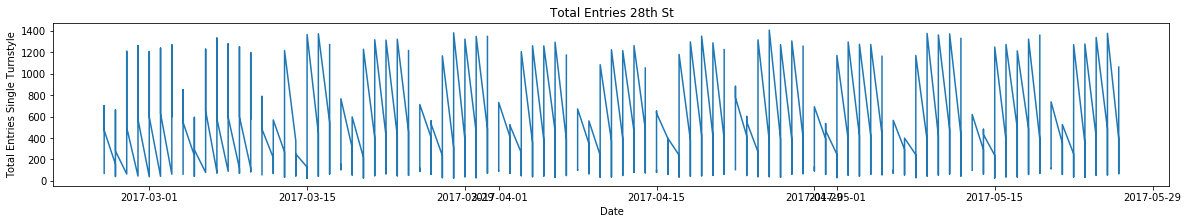

In [90]:
# plotting the daily time-series for a turnstyle

plt.figure(figsize=(20,3))
plt.plot(dates,counts)
plt.title('Total Entries 28th St')
plt.xlabel('Date')
plt.ylabel('Total Entries Single Turnstyle')

In [92]:
# creating time series for all turnstiles within the station

df_TurnCombo = df_top_stations.reset_index().drop('scp',axis=1)
df_TurnCombo = df_top_stations.groupby(['area','unit','station','date'])['total_traffic'].sum()
df_TurnCombo.head()

area  unit  station  date      
A027  R082  28 ST    02/25/2017     8243.0
                     02/26/2017     7064.0
                     02/27/2017    12532.0
                     02/28/2017    13665.0
                     03/01/2017    13422.0
Name: total_traffic, dtype: float64

In [93]:
# creating a time series for the entire station

df_StatCombo = df_TurnCombo.reset_index().drop(['area','unit'],axis=1)
df_StatCombo = df_StatCombo.groupby(['station','date'])['total_traffic'].sum()

df_StatCombo.head(7)

station  date      
14 ST    02/25/2017     52281.0
         02/26/2017     48343.0
         02/27/2017     98774.0
         02/28/2017    106056.0
         03/01/2017    106520.0
         03/02/2017    110986.0
         03/03/2017    110671.0
Name: total_traffic, dtype: float64

In [ ]:
# df_Stat23 = df_StatCombo[df_StatCombo['station'] == '14 ST']

# dates = [dateutil.parser.parse(date) for date in df_Stat23['date'].values]
# counts = df_Stat23['total_traffic'].values

In [104]:
df_hourly = df_top_stations.groupby(['station','date','time'])['total_traffic'].sum()
df_hourly.head(10)

station  date        time    
14 ST    02/25/2017  00:00:00        0.0
                     03:00:00        0.0
                     04:00:00     1340.0
                     07:00:00      976.0
                     08:00:00      940.0
                     11:00:00     3745.0
                     12:00:00     3820.0
                     15:00:00     8445.0
                     16:00:00     6876.0
                     19:00:00    11632.0
Name: total_traffic, dtype: float64

In [98]:
df_hourly = df_hourly.to_frame()

In [99]:
type(df_hourly)

pandas.core.frame.DataFrame

In [101]:
df_hourly.head()

total_traffic
station date       time                   
14 ST   02/25/2017 00:00:00            0.0
                   03:00:00            0.0
                   04:00:00         1340.0
                   07:00:00          976.0
                   08:00:00          940.0

In [107]:
# convert top stations to datetime
df_top_stations['date'] = pd.to_datetime(df_top_stations['date'])


/Users/nicksherwin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [108]:
# add day of the week column
df_top_stations['weekday'] = df_top_stations['date'].dt.dayofweek

/Users/nicksherwin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [109]:
df_top_stations['parsed_time'] = df_top_stations['time'].apply(parse)


/Users/nicksherwin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [111]:
df_top_stations.head()

area  unit       scp station linename division       date      time  \
3563  A027  R082  01-00-00   28 ST      NRW      BMT 2017-04-08  00:00:00   
3564  A027  R082  01-00-00   28 ST      NRW      BMT 2017-04-08  04:00:00   
3565  A027  R082  01-00-00   28 ST      NRW      BMT 2017-04-08  08:00:00   
3566  A027  R082  01-00-00   28 ST      NRW      BMT 2017-04-08  12:00:00   
3567  A027  R082  01-00-00   28 ST      NRW      BMT 2017-04-08  16:00:00   

         desc  entries    exits  entries_diff  exits_diff  total_traffic  \
3563  REGULAR  2350866  2859960           NaN         NaN            NaN   
3564  REGULAR  2350925  2860003          59.0        43.0          102.0   
3565  REGULAR  2350947  2860080          22.0        77.0           99.0   
3566  REGULAR  2351043  2860449          96.0       369.0          465.0   
3567  REGULAR  2351253  2860839         210.0       390.0          600.0   

      weekday         parsed_time  
3563        5 2019-07-07 00:00:00  
3564        5 2019-07-07 04:00:00  
3565        5 2019-07-07 08:00:00  
3566        5 2019-07-07 12:00:00  
3567        5 2019-07-07 16:00:00

In [112]:
#drop weekends
df_top_stations = df_top_stations[df_top_stations['weekday'].isin([0,1,2,3,4])]

In [113]:
total_by_station = df_top_stations.groupby(by='station', as_index=False).sum()[['station','total_traffic']].sort_values('total_traffic', ascending=False)

In [114]:
# find the weekly traffic 
total_by_station['weekly_traffic'] = total_by_station['total_traffic']/6


Text(0.5, 1.0, 'Total Weekday Traffic Per Week')

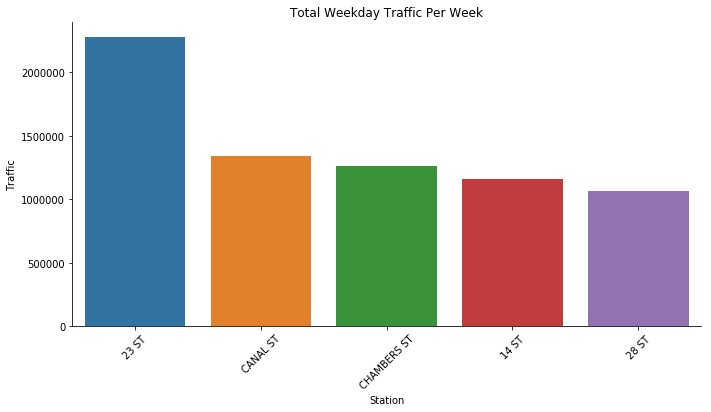

In [116]:
# plot weekly traffic in total
weekdays = sns.catplot('station', 'weekly_traffic', data = total_by_station, kind = 'bar', aspect = 2)
plt.xticks(rotation=45)
plt.xlabel('Station')
plt.ylabel('Traffic')
plt.title("Total Weekday Traffic Per Week")


In [123]:
# create a list parsed by time for our five candidate stations

top_stations_lst = ['23 ST',
                   'CANAL ST',
                   'CHAMBERS ST',
                   '14 ST',
                   '28 ST']

top_stations = df_top_stations[df_top_stations['station'].isin(top_stations_lst)]
top_stations = top_stations.groupby(by=['station', 'parsed_time'], as_index=False).sum()[['station', 'parsed_time','total_traffic']]
top_stations.set_index('parsed_time', drop=True, inplace=True)
top_stations = top_stations.groupby(by=['station']).resample('4H').mean()
top_stations = top_stations.reset_index()

In [124]:
top_stations

station         parsed_time  total_traffic
0         14 ST 2019-07-07 00:00:00   2.383270e+05
1         14 ST 2019-07-07 04:00:00   9.489692e+03
2         14 ST 2019-07-07 08:00:00   8.372478e+04
3         14 ST 2019-07-07 12:00:00   5.112910e+05
4         14 ST 2019-07-07 16:00:00   5.467407e+05
5         14 ST 2019-07-07 20:00:00   5.483198e+05
6         23 ST 2019-07-07 00:00:00   3.937300e+05
7         23 ST 2019-07-07 04:00:00   7.486789e+03
8         23 ST 2019-07-07 08:00:00   1.083426e+05
9         23 ST 2019-07-07 12:00:00   1.089675e+06
10        23 ST 2019-07-07 16:00:00   1.072255e+06
11        23 ST 2019-07-07 20:00:00   1.448506e+06
12        28 ST 2019-07-07 00:00:00   1.626407e+05
13        28 ST 2019-07-07 04:00:00   8.201250e+03
14        28 ST 2019-07-07 08:00:00   1.033434e+05
15        28 ST 2019-07-07 12:00:00   5.242187e+05
16        28 ST 2019-07-07 16:00:00   4.891380e+05
17        28 ST 2019-07-07 20:00:00   6.599347e+05
18     CANAL ST 2019-07-07 00:00:00   1.886093e+05
19     CANAL ST 2019-07-07 04:00:00   8.027667e+03
20     CANAL ST 2019-07-07 08:00:00   4.933924e+04
21     CANAL ST 2019-07-07 12:00:00   3.197827e+05
22     CANAL ST 2019-07-07 16:00:00   2.888361e+05
23     CANAL ST 2019-07-07 20:00:00   8.716493e+05
24  CHAMBERS ST 2019-07-07 00:00:00   2.518840e+05
25  CHAMBERS ST 2019-07-07 04:00:00   1.663320e+04
26  CHAMBERS ST 2019-07-07 08:00:00   1.689936e+05
27  CHAMBERS ST 2019-07-07 12:00:00   6.345220e+05
28  CHAMBERS ST 2019-07-07 16:00:00   9.555580e+05
29  CHAMBERS ST 2019-07-07 20:00:00   1.168460e+06

In [131]:
#rename time labels for cleanliness

top_stations.loc[top_stations['parsed_time'] == '00:00:00', 'label'] = '8pm-12am'
top_stations.loc[top_stations['parsed_time'] == '04:00:00', 'label'] = '12am-4am'
top_stations.loc[top_stations['parsed_time'] == '08:00:00', 'label'] = '4am-8am'
top_stations.loc[top_stations['parsed_time'] == '12:00:00', 'label'] = '8am-12pm'
top_stations.loc[top_stations['parsed_time'] == '16:00:00', 'label'] = '12pm-4pm'
top_stations.loc[top_stations['parsed_time'] == '20:00:00', 'label'] = '4pm-8pm'

Text(0.5, 1.0, 'Traffic flow')

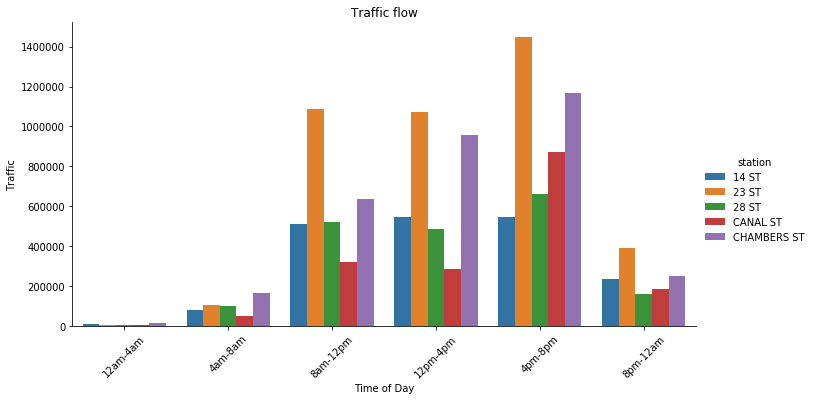

In [132]:
# plot traffic flow by time of day

order = ['12am-4am', '4am-8am', '8am-12pm', '12pm-4pm', '4pm-8pm', '8pm-12am']

flow_bar = sns.catplot('label', 'total_traffic', hue ='station', kind = 'bar', data = top_stations, aspect = 2, order=order)
plt.xticks(rotation=45)
plt.xlabel('Time of Day')
plt.ylabel('Traffic')
plt.title("Traffic flow")

In [134]:
# create a list parsed by weekday for our candidate stations

stations_by_weekday = df_top_stations[df_top_stations['station'].isin(top_stations_lst)]
stations_by_weekday = stations_by_weekday.groupby(by=['station', 'weekday'], as_index=False).sum()[['station', 'weekday','total_traffic']]
stations_by_weekday

station  weekday  total_traffic
0         14 ST        0      1290377.0
1         14 ST        1      1318879.0
2         14 ST        2      1428974.0
3         14 ST        3      1473474.0
4         14 ST        4      1447540.0
5         23 ST        0      2556566.0
6         23 ST        1      2642585.0
7         23 ST        2      2846219.0
8         23 ST        3      2927904.0
9         23 ST        4      2698267.0
10        28 ST        0      1205803.0
11        28 ST        1      1233078.0
12        28 ST        2      1314763.0
13        28 ST        3      1356009.0
14        28 ST        4      1290500.0
15     CANAL ST        0      1550858.0
16     CANAL ST        1      1514944.0
17     CANAL ST        2      1630471.0
18     CANAL ST        3      1673096.0
19     CANAL ST        4      1662972.0
20  CHAMBERS ST        0      1459051.0
21  CHAMBERS ST        1      1484473.0
22  CHAMBERS ST        2      1580373.0
23  CHAMBERS ST        3      1601206.0
24  CHAMBERS ST        4      1458400.0

In [135]:
# rename labels by day of week

stations_by_weekday.loc[stations_by_weekday['weekday'] == 0, 'label'] = 'Monday'
stations_by_weekday.loc[stations_by_weekday['weekday'] == 1, 'label'] = 'Tuesday'
stations_by_weekday.loc[stations_by_weekday['weekday'] == 2, 'label'] = 'Wednesday'
stations_by_weekday.loc[stations_by_weekday['weekday'] == 3, 'label'] = 'Thursday'
stations_by_weekday.loc[stations_by_weekday['weekday'] == 4, 'label'] = 'Friday'

Text(0.5, 1.0, 'Traffic flow by Weekday')

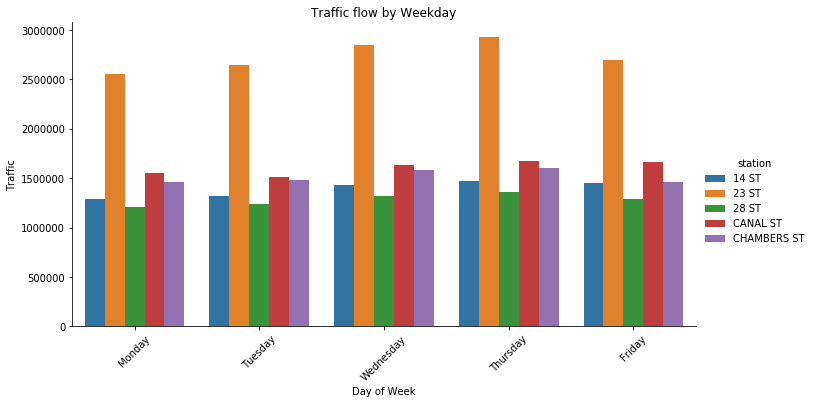

In [137]:
# plot traffic flow by weekday

weekday_bar = sns.catplot('label', 'total_traffic', hue ='station', kind = 'bar', data = stations_by_weekday, aspect = 2)
plt.xticks(rotation=45)
plt.xlabel('Day of Week')
plt.ylabel('Traffic')
plt.title("Traffic flow by Weekday")